In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# import the required libraries
import numpy as np
import pickle
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.regularizers import *
from tensorflow.keras import backend as keras
import tensorflow as tf
from PIL import Image, ImageOps
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import pandas as pd

Mounted at /content/drive


In [ ]:
def UNet_MCD(input_size, reg_fn, dropout_rate):
    inputs = Input(shape=input_size)

    conv1 = Conv2D(8, 3, activation='relu', padding='same', kernel_regularizer=reg_fn)(inputs)
    # conv1 = Dropout(dropout_rate)(conv1, training=True)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(16, 3, activation='relu', padding='same', kernel_regularizer=reg_fn)(pool1)
    # conv2 = Dropout(dropout_rate)(conv2, training=True)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(32, 3, activation='relu', padding='same', kernel_regularizer=reg_fn)(pool2)
    # conv3 = Dropout(dropout_rate)(conv3, training=True)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(64, 3, activation='relu', padding='same', kernel_regularizer=reg_fn)(pool3)
    conv4 = Dropout(dropout_rate)(conv4, training=True)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(128, 3, activation='relu', padding='same', kernel_regularizer=reg_fn)(pool4)
    conv5 = Dropout(dropout_rate)(conv5, training=True)
    pool5 = MaxPooling2D(pool_size=(2, 2))(conv5)

    conv6 = Conv2D(256, 3, activation='relu', padding='same', kernel_regularizer=reg_fn)(pool5)
    conv6 = Dropout(dropout_rate)(conv6, training=True)
    pool6 = MaxPooling2D(pool_size=(2, 2))(conv6)
      
    up7 = Conv2DTranspose(128, 2, strides=(2, 2), activation='relu', padding='same', kernel_regularizer=reg_fn)(pool6)
    up7 = Dropout(dropout_rate)(up7, training=True)
    sc7 = Concatenate()([up7, pool5])

    up8 = Conv2DTranspose(64, 2, strides=(2, 2), activation='relu', padding='same', kernel_regularizer=reg_fn)(sc7)
    up8 = Dropout(dropout_rate)(up8, training=True)
    sc8 = Concatenate()([up8, pool4])

    up9 = Conv2DTranspose(32, 2, strides=(2, 2), activation='relu', padding='same', kernel_regularizer=reg_fn)(sc8)
    # up9 = Dropout(dropout_rate)(up9, training=True)
    sc9 = Concatenate()([up9, pool3])

    up10 = Conv2DTranspose(16, 2, strides=(2, 2), activation='relu', padding='same', kernel_regularizer=reg_fn)(sc9)
    # up10 = Dropout(dropout_rate)(up10, training=True)
    sc10 = Concatenate()([up10, pool2])

    up11 = Conv2DTranspose(8, 2, strides=(2, 2), activation='relu', padding='same', kernel_regularizer=reg_fn)(sc10)
    # up11 = Dropout(dropout_rate)(up11, training=True)
    sc11 = Concatenate()([up11, pool1])

    outputs = Conv2DTranspose(1, 2, strides=(2, 2), activation='relu', padding='same', kernel_regularizer=reg_fn)(sc11)
    
    model = Model(inputs, outputs)

    model.compile(optimizer='adam', metrics=['accuracy'], loss=tf.keras.losses.MeanSquaredError())

    return model

In [ ]:
x_test = np.load('/content/drive/MyDrive/Rings_without_Noise/xtest_16_17.npz')
x_test = x_test['arr_0']
x_test = x_test.astype('float32')

y_test = np.load('/content/drive/MyDrive/Rings_without_Noise/ytest_16_17.npz')
y_test = y_test['arr_0']
y_test = y_test.astype('float32')

In [ ]:
max_val_den = 1e19
max_val_erms = 13.32106

In [ ]:
num_img = y_test.shape[0]
m_test = y_test.shape[1]
n_test = y_test.shape[2]
num_img

109

In [ ]:
test =[]
test.append(x_test[22])
test = np.asarray(test)
test.shape

(1, 256, 256, 1)

In [ ]:
model = UNet_MCD((256,256,1),l1(1e-6),0.1)

In [ ]:
model.load_weights('/content/drive/MyDrive/Rings_without_Noise/MC_P_1/1e-06_MCD_P_1.h5')

In [ ]:
op = np.empty((100,256,256,1))
for i in range(100):
  op[i] = model.predict(test)

In [ ]:
y_test /= 255.0
y_test *= max_val_den

In [ ]:
op /= 255.0
op *= max_val_den

In [ ]:
se = np.mean(op, axis = 0)
std = np.std(op, axis = 0)

In [ ]:
z1 = 1.645
z2 = 1.96
z3 = 2.576

In [ ]:
upper_1 = se[int(m_test/2)] + (z1 * (std[int(m_test/2)]/np.sqrt(100.0)))
lower_1 = se[int(m_test/2)] - (z1 * (std[int(m_test/2)]/np.sqrt(100.0)))

upper_2 = se[int(m_test/2)] + (z2 * (std[int(m_test/2)]/np.sqrt(100.0)))
lower_2 = se[int(m_test/2)] - (z2 * (std[int(m_test/2)]/np.sqrt(100.0)))

upper_3 = se[int(m_test/2)] + (z3 * (std[int(m_test/2)]/np.sqrt(100.0)))
lower_3 = se[int(m_test/2)] - (z3 * (std[int(m_test/2)]/np.sqrt(100.0)))

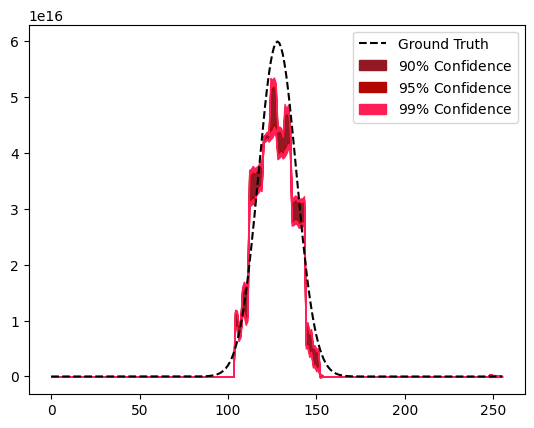

In [ ]:
plt.plot(np.arange(m_test), y_test[22][int(m_test/2)], linestyle='--', color='#000000',label='Ground Truth')
plt.fill_between(np.arange(m_test), lower_1.squeeze(), upper_1.squeeze(), color='#931A25', label='90$\%$ Confidence')
plt.fill_between(np.arange(m_test), lower_2.squeeze(), lower_1.squeeze(), color='#B20600')
plt.fill_between(np.arange(m_test), upper_2.squeeze(), upper_1.squeeze(), color='#B20600', label='95$\%$ Confidence')
plt.fill_between(np.arange(m_test), lower_3.squeeze(), lower_2.squeeze(), color='#FF1E56', label='99$\%$ Confidence')
plt.fill_between(np.arange(m_test), upper_3.squeeze(), upper_2.squeeze(), color='#FF1E56')
plt.legend()

In [ ]:
x_test = np.load('/content/drive/MyDrive/Rings_without_Noise/xtest_17_18.npz')
x_test = x_test['arr_0']
x_test = x_test.astype('float32')

y_test = np.load('/content/drive/MyDrive/Rings_without_Noise/ytest_17_18.npz')
y_test = y_test['arr_0']
y_test = y_test.astype('float32')

In [ ]:
max_val_den = 1e19
max_val_erms = 13.32106

In [ ]:
num_img = y_test.shape[0]
m_test = y_test.shape[1]
n_test = y_test.shape[2]
num_img

116

In [ ]:
test =[]
test.append(x_test[22])
test = np.asarray(test)
test.shape

(1, 256, 256, 1)

In [ ]:
model = UNet_MCD((256,256,1),l1(1e-6),0.1)

In [ ]:
model.load_weights('/content/drive/MyDrive/Rings_without_Noise/MC_P_1/1e-06_MCD_P_1.h5')

In [ ]:
op = np.empty((100,256,256,1))
for i in range(100):
  op[i] = model.predict(test)

In [ ]:
y_test /= 255.0
y_test *= max_val_den

In [ ]:
op /= 255.0
op *= max_val_den

In [ ]:
se = np.mean(op, axis = 0)
std = np.std(op, axis = 0)

In [ ]:
z1 = 1.645
z2 = 1.96
z3 = 2.576

In [ ]:
upper_1 = se[int(m_test/2)] + (z1 * (std[int(m_test/2)]/np.sqrt(100.0)))
lower_1 = se[int(m_test/2)] - (z1 * (std[int(m_test/2)]/np.sqrt(100.0)))

upper_2 = se[int(m_test/2)] + (z2 * (std[int(m_test/2)]/np.sqrt(100.0)))
lower_2 = se[int(m_test/2)] - (z2 * (std[int(m_test/2)]/np.sqrt(100.0)))

upper_3 = se[int(m_test/2)] + (z3 * (std[int(m_test/2)]/np.sqrt(100.0)))
lower_3 = se[int(m_test/2)] - (z3 * (std[int(m_test/2)]/np.sqrt(100.0)))

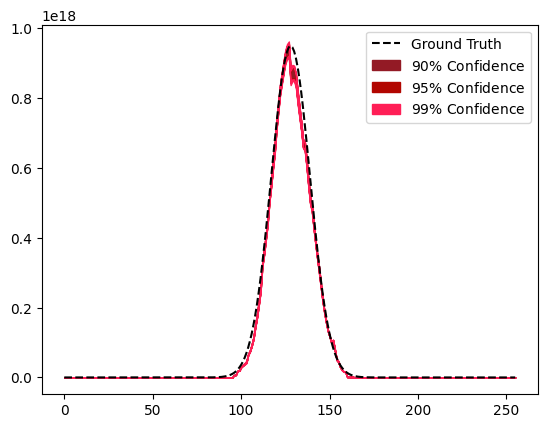

In [ ]:
plt.plot(np.arange(m_test), y_test[22][int(m_test/2)], linestyle='--', color='#000000',label='Ground Truth')
plt.fill_between(np.arange(m_test), lower_1.squeeze(), upper_1.squeeze(), color='#931A25', label='90$\%$ Confidence')
plt.fill_between(np.arange(m_test), lower_2.squeeze(), lower_1.squeeze(), color='#B20600')
plt.fill_between(np.arange(m_test), upper_2.squeeze(), upper_1.squeeze(), color='#B20600', label='95$\%$ Confidence')
plt.fill_between(np.arange(m_test), lower_3.squeeze(), lower_2.squeeze(), color='#FF1E56', label='99$\%$ Confidence')
plt.fill_between(np.arange(m_test), upper_3.squeeze(), upper_2.squeeze(), color='#FF1E56')
plt.legend()

In [ ]:
x_test = np.load('/content/drive/MyDrive/Rings_without_Noise/xtest_18_19.npz')
x_test = x_test['arr_0']
x_test = x_test.astype('float32')

y_test = np.load('/content/drive/MyDrive/Rings_without_Noise/ytest_18_19.npz')
y_test = y_test['arr_0']
y_test = y_test.astype('float32')

In [ ]:
max_val_den = 1e19
max_val_erms = 13.32106

In [ ]:
num_img = y_test.shape[0]
m_test = y_test.shape[1]
n_test = y_test.shape[2]
num_img

105

In [ ]:
test =[]
test.append(x_test[22])
test = np.asarray(test)
test.shape

(1, 256, 256, 1)

In [ ]:
model = UNet_MCD((256,256,1),l1(1e-6),0.1)

In [ ]:
model.load_weights('/content/drive/MyDrive/Rings_without_Noise/MC_P_1/1e-06_MCD_P_1.h5')

In [ ]:
op = np.empty((100,256,256,1))
for i in range(100):
  op[i] = model.predict(test)

In [ ]:
y_test /= 255.0
y_test *= max_val_den

In [ ]:
op /= 255.0
op *= max_val_den

In [ ]:
se = np.mean(op, axis = 0)
std = np.std(op, axis = 0)

In [ ]:
z1 = 1.645
z2 = 1.96
z3 = 2.576

In [ ]:
upper_1 = se[int(m_test/2)] + (z1 * (std[int(m_test/2)]/np.sqrt(100.0)))
lower_1 = se[int(m_test/2)] - (z1 * (std[int(m_test/2)]/np.sqrt(100.0)))

upper_2 = se[int(m_test/2)] + (z2 * (std[int(m_test/2)]/np.sqrt(100.0)))
lower_2 = se[int(m_test/2)] - (z2 * (std[int(m_test/2)]/np.sqrt(100.0)))

upper_3 = se[int(m_test/2)] + (z3 * (std[int(m_test/2)]/np.sqrt(100.0)))
lower_3 = se[int(m_test/2)] - (z3 * (std[int(m_test/2)]/np.sqrt(100.0)))

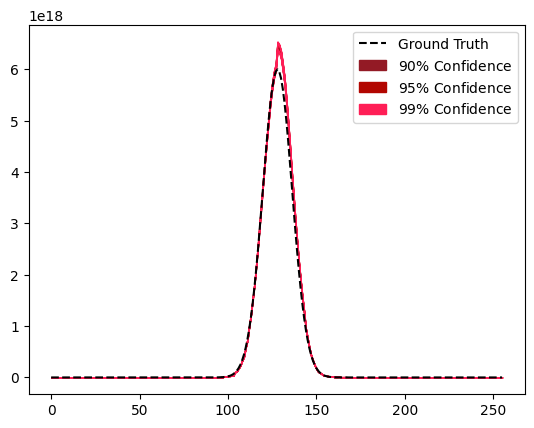

In [ ]:
plt.plot(np.arange(m_test), y_test[22][int(m_test/2)], linestyle='--', color='#000000',label='Ground Truth')
plt.fill_between(np.arange(m_test), lower_1.squeeze(), upper_1.squeeze(), color='#931A25', label='90$\%$ Confidence')
plt.fill_between(np.arange(m_test), lower_2.squeeze(), lower_1.squeeze(), color='#B20600')
plt.fill_between(np.arange(m_test), upper_2.squeeze(), upper_1.squeeze(), color='#B20600', label='95$\%$ Confidence')
plt.fill_between(np.arange(m_test), lower_3.squeeze(), lower_2.squeeze(), color='#FF1E56', label='99$\%$ Confidence')
plt.fill_between(np.arange(m_test), upper_3.squeeze(), upper_2.squeeze(), color='#FF1E56')
plt.legend()

# **Concentric Rings With Noise**

In [ ]:
x_test = np.load('/content/drive/MyDrive/Rings_with_Noise/xtest_16_17.npz')
x_test = x_test['arr_0']
x_test = x_test.astype('float32')

y_test = np.load('/content/drive/MyDrive/Rings_with_Noise/ytest_16_17.npz')
y_test = y_test['arr_0']
y_test = y_test.astype('float32')

In [ ]:
max_val_den = 1e19
max_val_erms = 13.32106

In [ ]:
num_img = y_test.shape[0]
m_test = y_test.shape[1]
n_test = y_test.shape[2]
num_img

117

In [ ]:
test =[]
test.append(x_test[22])
test = np.asarray(test)
test.shape

(1, 256, 256, 1)

In [ ]:
model = UNet_MCD((256,256,1),l1(1e-6),0.1)
model.load_weights('/content/drive/MyDrive/Rings_with_Noise/MC_P_1/1e-06_MCD_P_1.h5')

In [ ]:
op = np.empty((100,256,256,1))
for i in range(100):
  op[i] = model.predict(test)

In [ ]:
y_test /= 255.0
y_test *= max_val_den

In [ ]:
op /= 255.0
op *= max_val_den

In [ ]:
se = np.mean(op, axis = 0)
std = np.std(op, axis = 0)

In [ ]:
z1 = 1.645
z2 = 1.96
z3 = 2.576

In [ ]:
upper_1 = se[int(m_test/2)] + (z1 * (std[int(m_test/2)]/np.sqrt(100.0)))
lower_1 = se[int(m_test/2)] - (z1 * (std[int(m_test/2)]/np.sqrt(100.0)))

upper_2 = se[int(m_test/2)] + (z2 * (std[int(m_test/2)]/np.sqrt(100.0)))
lower_2 = se[int(m_test/2)] - (z2 * (std[int(m_test/2)]/np.sqrt(100.0)))

upper_3 = se[int(m_test/2)] + (z3 * (std[int(m_test/2)]/np.sqrt(100.0)))
lower_3 = se[int(m_test/2)] - (z3 * (std[int(m_test/2)]/np.sqrt(100.0)))

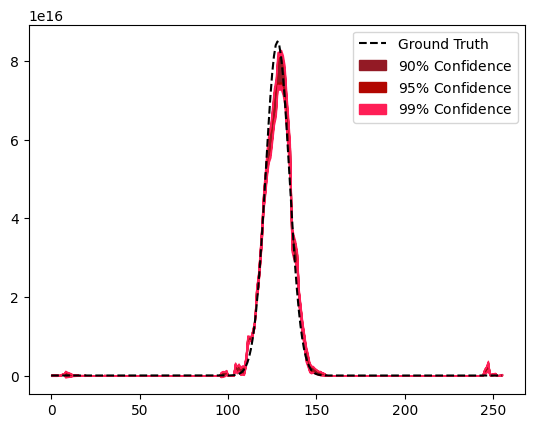

In [ ]:
plt.plot(np.arange(m_test), y_test[22][int(m_test/2)], linestyle='--', color='#000000',label='Ground Truth')
plt.fill_between(np.arange(m_test), lower_1.squeeze(), upper_1.squeeze(), color='#931A25', label='90$\%$ Confidence')
plt.fill_between(np.arange(m_test), lower_2.squeeze(), lower_1.squeeze(), color='#B20600')
plt.fill_between(np.arange(m_test), upper_2.squeeze(), upper_1.squeeze(), color='#B20600', label='95$\%$ Confidence')
plt.fill_between(np.arange(m_test), lower_3.squeeze(), lower_2.squeeze(), color='#FF1E56', label='99$\%$ Confidence')
plt.fill_between(np.arange(m_test), upper_3.squeeze(), upper_2.squeeze(), color='#FF1E56')
plt.legend()

In [ ]:
x_test = np.load('/content/drive/MyDrive/Rings_with_Noise/xtest_17_18.npz')
x_test = x_test['arr_0']
x_test = x_test.astype('float32')

y_test = np.load('/content/drive/MyDrive/Rings_with_Noise/ytest_17_18.npz')
y_test = y_test['arr_0']
y_test = y_test.astype('float32')

In [ ]:
max_val_den = 1e19
max_val_erms = 13.32106

In [ ]:
num_img = y_test.shape[0]
m_test = y_test.shape[1]
n_test = y_test.shape[2]
num_img

95

In [ ]:
test =[]
test.append(x_test[22])
test = np.asarray(test)
test.shape

(1, 256, 256, 1)

In [ ]:
model = UNet_MCD((256,256,1),l1(1e-6),0.1)
model.load_weights('/content/drive/MyDrive/Rings_with_Noise/MC_P_1/1e-06_MCD_P_1.h5')

In [ ]:
op = np.empty((100,256,256,1))
for i in range(100):
  op[i] = model.predict(test)

In [ ]:
y_test /= 255.0
y_test *= max_val_den

In [ ]:
op /= 255.0
op *= max_val_den

In [ ]:
se = np.mean(op, axis = 0)
std = np.std(op, axis = 0)

In [ ]:
z1 = 1.645
z2 = 1.96
z3 = 2.576

In [ ]:
upper_1 = se[int(m_test/2)] + (z1 * (std[int(m_test/2)]/np.sqrt(100.0)))
lower_1 = se[int(m_test/2)] - (z1 * (std[int(m_test/2)]/np.sqrt(100.0)))

upper_2 = se[int(m_test/2)] + (z2 * (std[int(m_test/2)]/np.sqrt(100.0)))
lower_2 = se[int(m_test/2)] - (z2 * (std[int(m_test/2)]/np.sqrt(100.0)))

upper_3 = se[int(m_test/2)] + (z3 * (std[int(m_test/2)]/np.sqrt(100.0)))
lower_3 = se[int(m_test/2)] - (z3 * (std[int(m_test/2)]/np.sqrt(100.0)))

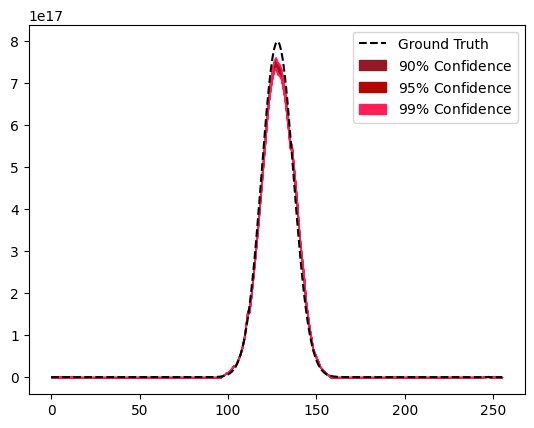

In [ ]:
plt.plot(np.arange(m_test), y_test[22][int(m_test/2)], linestyle='--', color='#000000',label='Ground Truth')
plt.fill_between(np.arange(m_test), lower_1.squeeze(), upper_1.squeeze(), color='#931A25', label='90$\%$ Confidence')
plt.fill_between(np.arange(m_test), lower_2.squeeze(), lower_1.squeeze(), color='#B20600')
plt.fill_between(np.arange(m_test), upper_2.squeeze(), upper_1.squeeze(), color='#B20600', label='95$\%$ Confidence')
plt.fill_between(np.arange(m_test), lower_3.squeeze(), lower_2.squeeze(), color='#FF1E56', label='99$\%$ Confidence')
plt.fill_between(np.arange(m_test), upper_3.squeeze(), upper_2.squeeze(), color='#FF1E56')
plt.legend()

In [ ]:
x_test = np.load('/content/drive/MyDrive/Rings_with_Noise/xtest_18_19.npz')
x_test = x_test['arr_0']
x_test = x_test.astype('float32')

y_test = np.load('/content/drive/MyDrive/Rings_with_Noise/ytest_18_19.npz')
y_test = y_test['arr_0']
y_test = y_test.astype('float32')

In [ ]:
max_val_den = 1e19
max_val_erms = 13.32106

In [ ]:
num_img = y_test.shape[0]
m_test = y_test.shape[1]
n_test = y_test.shape[2]
num_img

118

In [ ]:
test =[]
test.append(x_test[22])
test = np.asarray(test)
test.shape

(1, 256, 256, 1)

In [ ]:
model = UNet_MCD((256,256,1),l1(1e-6),0.1)
model.load_weights('/content/drive/MyDrive/Rings_with_Noise/MC_P_1/1e-06_MCD_P_1.h5')

In [ ]:
op = np.empty((100,256,256,1))
for i in range(100):
  op[i] = model.predict(test)

In [ ]:
y_test /= 255.0
y_test *= max_val_den

In [ ]:
op /= 255.0
op *= max_val_den

In [ ]:
se = np.mean(op, axis = 0)
std = np.std(op, axis = 0)

In [ ]:
z1 = 1.645
z2 = 1.96
z3 = 2.576

In [ ]:
upper_1 = se[int(m_test/2)] + (z1 * (std[int(m_test/2)]/np.sqrt(100.0)))
lower_1 = se[int(m_test/2)] - (z1 * (std[int(m_test/2)]/np.sqrt(100.0)))

upper_2 = se[int(m_test/2)] + (z2 * (std[int(m_test/2)]/np.sqrt(100.0)))
lower_2 = se[int(m_test/2)] - (z2 * (std[int(m_test/2)]/np.sqrt(100.0)))

upper_3 = se[int(m_test/2)] + (z3 * (std[int(m_test/2)]/np.sqrt(100.0)))
lower_3 = se[int(m_test/2)] - (z3 * (std[int(m_test/2)]/np.sqrt(100.0)))

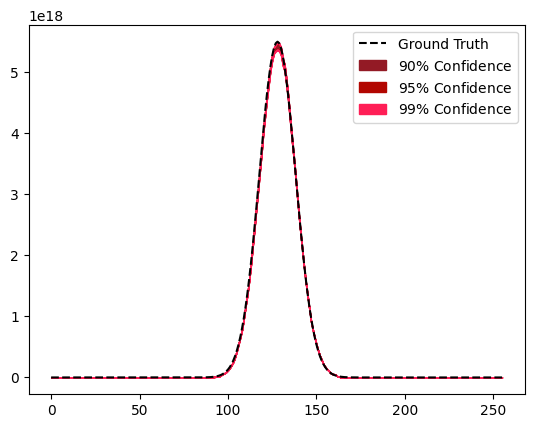

In [ ]:
plt.plot(np.arange(m_test), y_test[22][int(m_test/2)], linestyle='--', color='#000000',label='Ground Truth')
plt.fill_between(np.arange(m_test), lower_1.squeeze(), upper_1.squeeze(), color='#931A25', label='90$\%$ Confidence')
plt.fill_between(np.arange(m_test), lower_2.squeeze(), lower_1.squeeze(), color='#B20600')
plt.fill_between(np.arange(m_test), upper_2.squeeze(), upper_1.squeeze(), color='#B20600', label='95$\%$ Confidence')
plt.fill_between(np.arange(m_test), lower_3.squeeze(), lower_2.squeeze(), color='#FF1E56', label='99$\%$ Confidence')
plt.fill_between(np.arange(m_test), upper_3.squeeze(), upper_2.squeeze(), color='#FF1E56')
plt.legend()

#**Disk without Noise**

In [ ]:
x_test = np.load('/content/drive/MyDrive/Disk/Without_Noise/xtest_16_17.npz')
x_test = x_test['arr_0']
x_test = x_test.astype('float32')

y_test = np.load('/content/drive/MyDrive/Disk/Without_Noise/ytest_16_17.npz')
y_test = y_test['arr_0']
y_test = y_test.astype('float32')

In [ ]:
max_val_den = 1e19
max_val_erms = 13.32106

In [ ]:
num_img = y_test.shape[0]
m_test = y_test.shape[1]
n_test = y_test.shape[2]
num_img

119

In [ ]:
test =[]
test.append(x_test[22])
test = np.asarray(test)
test.shape

(1, 256, 256, 1)

In [ ]:
model = UNet_MCD((256,256,1),l1(1e-6),0.1)
model.load_weights('/content/drive/MyDrive/Disk/Without_Noise/P_1/1e-06_MCD_P_1.h5')

In [ ]:
op = np.empty((100,256,256,1))
for i in range(100):
  op[i] = model.predict(test)

In [ ]:
y_test /= 255.0
y_test *= max_val_den

In [ ]:
op /= 255.0
op *= max_val_den

In [ ]:
se = np.mean(op, axis = 0)
std = np.std(op, axis = 0)

In [ ]:
z1 = 1.645
z2 = 1.96
z3 = 2.576

In [ ]:
upper_1 = se[int(m_test/2)] + (z1 * (std[int(m_test/2)]/np.sqrt(100.0)))
lower_1 = se[int(m_test/2)] - (z1 * (std[int(m_test/2)]/np.sqrt(100.0)))

upper_2 = se[int(m_test/2)] + (z2 * (std[int(m_test/2)]/np.sqrt(100.0)))
lower_2 = se[int(m_test/2)] - (z2 * (std[int(m_test/2)]/np.sqrt(100.0)))

upper_3 = se[int(m_test/2)] + (z3 * (std[int(m_test/2)]/np.sqrt(100.0)))
lower_3 = se[int(m_test/2)] - (z3 * (std[int(m_test/2)]/np.sqrt(100.0)))

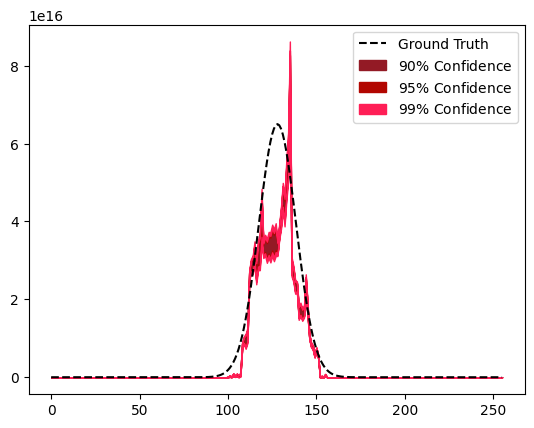

In [ ]:
plt.plot(np.arange(m_test), y_test[22][int(m_test/2)], linestyle='--', color='#000000',label='Ground Truth')
plt.fill_between(np.arange(m_test), lower_1.squeeze(), upper_1.squeeze(), color='#931A25', label='90$\%$ Confidence')
plt.fill_between(np.arange(m_test), lower_2.squeeze(), lower_1.squeeze(), color='#B20600')
plt.fill_between(np.arange(m_test), upper_2.squeeze(), upper_1.squeeze(), color='#B20600', label='95$\%$ Confidence')
plt.fill_between(np.arange(m_test), lower_3.squeeze(), lower_2.squeeze(), color='#FF1E56', label='99$\%$ Confidence')
plt.fill_between(np.arange(m_test), upper_3.squeeze(), upper_2.squeeze(), color='#FF1E56')
plt.legend()

In [ ]:
x_test = np.load('/content/drive/MyDrive/Disk/Without_Noise/xtest_17_18.npz')
x_test = x_test['arr_0']
x_test = x_test.astype('float32')

y_test = np.load('/content/drive/MyDrive/Disk/Without_Noise/ytest_17_18.npz')
y_test = y_test['arr_0']
y_test = y_test.astype('float32')

In [ ]:
max_val_den = 1e19
max_val_erms = 13.32106

In [ ]:
num_img = y_test.shape[0]
m_test = y_test.shape[1]
n_test = y_test.shape[2]
num_img

111

In [ ]:
test =[]
test.append(x_test[22])
test = np.asarray(test)
test.shape

(1, 256, 256, 1)

In [ ]:
model = UNet_MCD((256,256,1),l1(1e-6),0.1)
model.load_weights('/content/drive/MyDrive/Disk/Without_Noise/P_1/1e-06_MCD_P_1.h5')

In [ ]:
op = np.empty((100,256,256,1))
for i in range(100):
  op[i] = model.predict(test)

In [ ]:
y_test /= 255.0
y_test *= max_val_den

In [ ]:
op /= 255.0
op *= max_val_den

In [ ]:
se = np.mean(op, axis = 0)
std = np.std(op, axis = 0)

In [ ]:
z1 = 1.645
z2 = 1.96
z3 = 2.576

In [ ]:
upper_1 = se[int(m_test/2)] + (z1 * (std[int(m_test/2)]/np.sqrt(100.0)))
lower_1 = se[int(m_test/2)] - (z1 * (std[int(m_test/2)]/np.sqrt(100.0)))

upper_2 = se[int(m_test/2)] + (z2 * (std[int(m_test/2)]/np.sqrt(100.0)))
lower_2 = se[int(m_test/2)] - (z2 * (std[int(m_test/2)]/np.sqrt(100.0)))

upper_3 = se[int(m_test/2)] + (z3 * (std[int(m_test/2)]/np.sqrt(100.0)))
lower_3 = se[int(m_test/2)] - (z3 * (std[int(m_test/2)]/np.sqrt(100.0)))

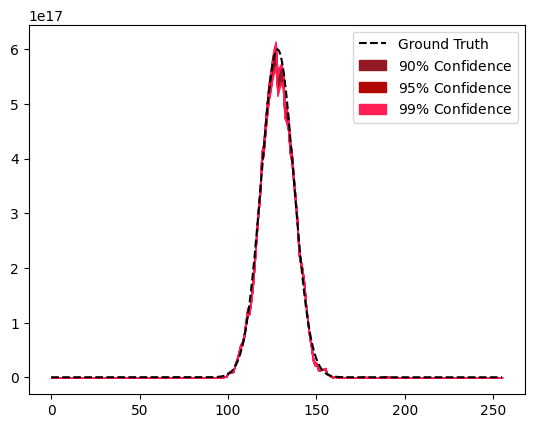

In [ ]:
plt.plot(np.arange(m_test), y_test[22][int(m_test/2)], linestyle='--', color='#000000',label='Ground Truth')
plt.fill_between(np.arange(m_test), lower_1.squeeze(), upper_1.squeeze(), color='#931A25', label='90$\%$ Confidence')
plt.fill_between(np.arange(m_test), lower_2.squeeze(), lower_1.squeeze(), color='#B20600')
plt.fill_between(np.arange(m_test), upper_2.squeeze(), upper_1.squeeze(), color='#B20600', label='95$\%$ Confidence')
plt.fill_between(np.arange(m_test), lower_3.squeeze(), lower_2.squeeze(), color='#FF1E56', label='99$\%$ Confidence')
plt.fill_between(np.arange(m_test), upper_3.squeeze(), upper_2.squeeze(), color='#FF1E56')
plt.legend()

In [ ]:
x_test = np.load('/content/drive/MyDrive/Disk/Without_Noise/xtest_18_19.npz')
x_test = x_test['arr_0']
x_test = x_test.astype('float32')

y_test = np.load('/content/drive/MyDrive/Disk/Without_Noise/ytest_18_19.npz')
y_test = y_test['arr_0']
y_test = y_test.astype('float32')

In [ ]:
max_val_den = 1e19
max_val_erms = 13.32106

In [ ]:
num_img = y_test.shape[0]
m_test = y_test.shape[1]
n_test = y_test.shape[2]
num_img

100

In [ ]:
test =[]
test.append(x_test[22])
test = np.asarray(test)
test.shape

(1, 256, 256, 1)

In [ ]:
model = UNet_MCD((256,256,1),l1(1e-6),0.1)
model.load_weights('/content/drive/MyDrive/Disk/Without_Noise/P_1/1e-06_MCD_P_1.h5')

In [ ]:
op = np.empty((100,256,256,1))
for i in range(100):
  op[i] = model.predict(test)

In [ ]:
y_test /= 255.0
y_test *= max_val_den

In [ ]:
op /= 255.0
op *= max_val_den

In [ ]:
se = np.mean(op, axis = 0)
std = np.std(op, axis = 0)

In [ ]:
z1 = 1.645
z2 = 1.96
z3 = 2.576

In [ ]:
upper_1 = se[int(m_test/2)] + (z1 * (std[int(m_test/2)]/np.sqrt(100.0)))
lower_1 = se[int(m_test/2)] - (z1 * (std[int(m_test/2)]/np.sqrt(100.0)))

upper_2 = se[int(m_test/2)] + (z2 * (std[int(m_test/2)]/np.sqrt(100.0)))
lower_2 = se[int(m_test/2)] - (z2 * (std[int(m_test/2)]/np.sqrt(100.0)))

upper_3 = se[int(m_test/2)] + (z3 * (std[int(m_test/2)]/np.sqrt(100.0)))
lower_3 = se[int(m_test/2)] - (z3 * (std[int(m_test/2)]/np.sqrt(100.0)))

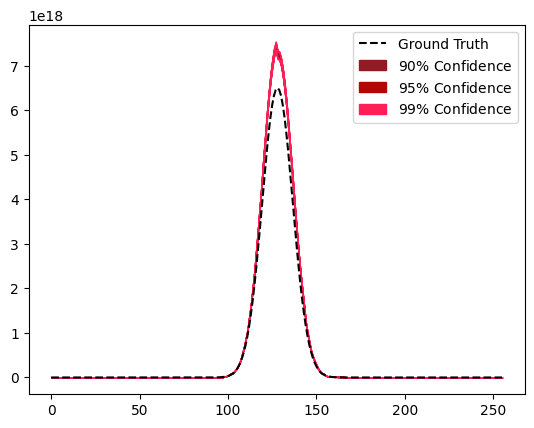

In [ ]:
plt.plot(np.arange(m_test), y_test[22][int(m_test/2)], linestyle='--', color='#000000',label='Ground Truth')
plt.fill_between(np.arange(m_test), lower_1.squeeze(), upper_1.squeeze(), color='#931A25', label='90$\%$ Confidence')
plt.fill_between(np.arange(m_test), lower_2.squeeze(), lower_1.squeeze(), color='#B20600')
plt.fill_between(np.arange(m_test), upper_2.squeeze(), upper_1.squeeze(), color='#B20600', label='95$\%$ Confidence')
plt.fill_between(np.arange(m_test), lower_3.squeeze(), lower_2.squeeze(), color='#FF1E56', label='99$\%$ Confidence')
plt.fill_between(np.arange(m_test), upper_3.squeeze(), upper_2.squeeze(), color='#FF1E56')
plt.legend()

## **Disk With Noise**

In [ ]:
x_test = np.load('/content/drive/MyDrive/Disk/With_Noise/xtest_16_17.npz')
x_test = x_test['arr_0']
x_test = x_test.astype('float32')

y_test = np.load('/content/drive/MyDrive/Disk/With_Noise/ytest_16_17.npz')
y_test = y_test['arr_0']
y_test = y_test.astype('float32')

In [ ]:
max_val_den = 1e19
max_val_erms = 13.32106

In [ ]:
num_img = y_test.shape[0]
m_test = y_test.shape[1]
n_test = y_test.shape[2]
num_img

112

In [ ]:
test =[]
test.append(x_test[22])
test = np.asarray(test)
test.shape

(1, 256, 256, 1)

In [ ]:
model = UNet_MCD((256,256,1),l1(1e-6),0.1)
model.load_weights('/content/drive/MyDrive/Disk/With_Noise/MC_P_1/1e-06_MCD_P_1.h5')

In [ ]:
op = np.empty((100,256,256,1))
for i in range(100):
  op[i] = model.predict(test)

In [ ]:
y_test /= 255.0
y_test *= max_val_den

In [ ]:
op /= 255.0
op *= max_val_den

In [ ]:
se = np.mean(op, axis = 0)
std = np.std(op, axis = 0)

In [ ]:
z1 = 1.645
z2 = 1.96
z3 = 2.576

In [ ]:
upper_1 = se[int(m_test/2)] + (z1 * (std[int(m_test/2)]/np.sqrt(100.0)))
lower_1 = se[int(m_test/2)] - (z1 * (std[int(m_test/2)]/np.sqrt(100.0)))

upper_2 = se[int(m_test/2)] + (z2 * (std[int(m_test/2)]/np.sqrt(100.0)))
lower_2 = se[int(m_test/2)] - (z2 * (std[int(m_test/2)]/np.sqrt(100.0)))

upper_3 = se[int(m_test/2)] + (z3 * (std[int(m_test/2)]/np.sqrt(100.0)))
lower_3 = se[int(m_test/2)] - (z3 * (std[int(m_test/2)]/np.sqrt(100.0)))

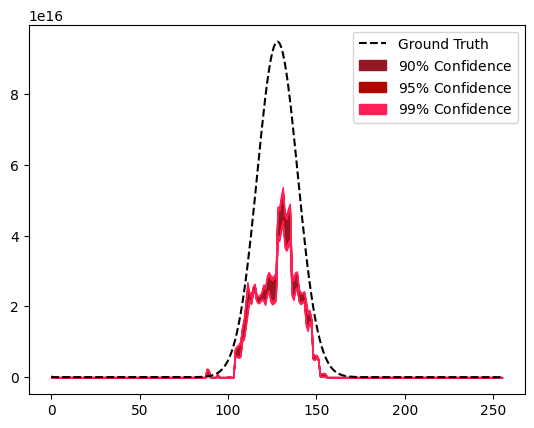

In [ ]:
plt.plot(np.arange(m_test), y_test[22][int(m_test/2)], linestyle='--', color='#000000',label='Ground Truth')
plt.fill_between(np.arange(m_test), lower_1.squeeze(), upper_1.squeeze(), color='#931A25', label='90$\%$ Confidence')
plt.fill_between(np.arange(m_test), lower_2.squeeze(), lower_1.squeeze(), color='#B20600')
plt.fill_between(np.arange(m_test), upper_2.squeeze(), upper_1.squeeze(), color='#B20600', label='95$\%$ Confidence')
plt.fill_between(np.arange(m_test), lower_3.squeeze(), lower_2.squeeze(), color='#FF1E56', label='99$\%$ Confidence')
plt.fill_between(np.arange(m_test), upper_3.squeeze(), upper_2.squeeze(), color='#FF1E56')
plt.legend()

In [ ]:
x_test = np.load('/content/drive/MyDrive/Disk/With_Noise/xtest_17_18.npz')
x_test = x_test['arr_0']
x_test = x_test.astype('float32')

y_test = np.load('/content/drive/MyDrive/Disk/With_Noise/ytest_17_18.npz')
y_test = y_test['arr_0']
y_test = y_test.astype('float32')

In [ ]:
max_val_den = 1e19
max_val_erms = 13.32106

In [ ]:
num_img = y_test.shape[0]
m_test = y_test.shape[1]
n_test = y_test.shape[2]
num_img

97

In [ ]:
test =[]
test.append(x_test[22])
test = np.asarray(test)
test.shape

(1, 256, 256, 1)

In [ ]:
model = UNet_MCD((256,256,1),l1(1e-6),0.1)
model.load_weights('/content/drive/MyDrive/Disk/With_Noise/MC_P_1/1e-06_MCD_P_1.h5')

In [ ]:
op = np.empty((100,256,256,1))
for i in range(100):
  op[i] = model.predict(test)

In [ ]:
y_test /= 255.0
y_test *= max_val_den

In [ ]:
op /= 255.0
op *= max_val_den

In [ ]:
se = np.mean(op, axis = 0)
std = np.std(op, axis = 0)

In [ ]:
z1 = 1.645
z2 = 1.96
z3 = 2.576

In [ ]:
upper_1 = se[int(m_test/2)] + (z1 * (std[int(m_test/2)]/np.sqrt(100.0)))
lower_1 = se[int(m_test/2)] - (z1 * (std[int(m_test/2)]/np.sqrt(100.0)))

upper_2 = se[int(m_test/2)] + (z2 * (std[int(m_test/2)]/np.sqrt(100.0)))
lower_2 = se[int(m_test/2)] - (z2 * (std[int(m_test/2)]/np.sqrt(100.0)))

upper_3 = se[int(m_test/2)] + (z3 * (std[int(m_test/2)]/np.sqrt(100.0)))
lower_3 = se[int(m_test/2)] - (z3 * (std[int(m_test/2)]/np.sqrt(100.0)))

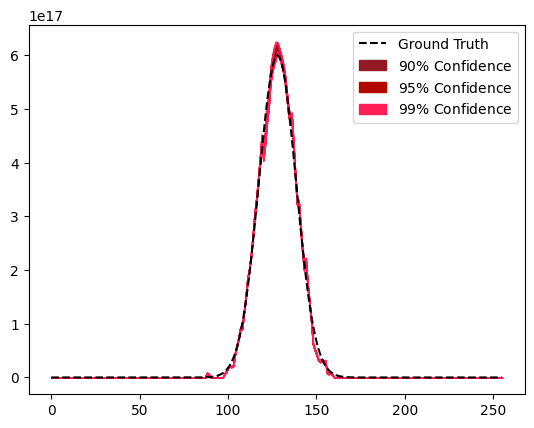

In [ ]:
plt.plot(np.arange(m_test), y_test[22][int(m_test/2)], linestyle='--', color='#000000',label='Ground Truth')
plt.fill_between(np.arange(m_test), lower_1.squeeze(), upper_1.squeeze(), color='#931A25', label='90$\%$ Confidence')
plt.fill_between(np.arange(m_test), lower_2.squeeze(), lower_1.squeeze(), color='#B20600')
plt.fill_between(np.arange(m_test), upper_2.squeeze(), upper_1.squeeze(), color='#B20600', label='95$\%$ Confidence')
plt.fill_between(np.arange(m_test), lower_3.squeeze(), lower_2.squeeze(), color='#FF1E56', label='99$\%$ Confidence')
plt.fill_between(np.arange(m_test), upper_3.squeeze(), upper_2.squeeze(), color='#FF1E56')
plt.legend()

In [ ]:
x_test = np.load('/content/drive/MyDrive/Disk/With_Noise/xtest_18_19.npz')
x_test = x_test['arr_0']
x_test = x_test.astype('float32')

y_test = np.load('/content/drive/MyDrive/Disk/With_Noise/ytest_18_19.npz')
y_test = y_test['arr_0']
y_test = y_test.astype('float32')

In [ ]:
max_val_den = 1e19
max_val_erms = 13.32106

In [ ]:
num_img = y_test.shape[0]
m_test = y_test.shape[1]
n_test = y_test.shape[2]
num_img

121

In [ ]:
test =[]
test.append(x_test[22])
test = np.asarray(test)
test.shape

(1, 256, 256, 1)

In [ ]:
model = UNet_MCD((256,256,1),l1(1e-6),0.1)
model.load_weights('/content/drive/MyDrive/Disk/With_Noise/MC_P_1/1e-06_MCD_P_1.h5')

In [ ]:
op = np.empty((100,256,256,1))
for i in range(100):
  op[i] = model.predict(test)

In [ ]:
y_test /= 255.0
y_test *= max_val_den

In [ ]:
op /= 255.0
op *= max_val_den

In [ ]:
se = np.mean(op, axis = 0)
std = np.std(op, axis = 0)

In [ ]:
z1 = 1.645
z2 = 1.96
z3 = 2.576

In [ ]:
upper_1 = se[int(m_test/2)] + (z1 * (std[int(m_test/2)]/np.sqrt(100.0)))
lower_1 = se[int(m_test/2)] - (z1 * (std[int(m_test/2)]/np.sqrt(100.0)))

upper_2 = se[int(m_test/2)] + (z2 * (std[int(m_test/2)]/np.sqrt(100.0)))
lower_2 = se[int(m_test/2)] - (z2 * (std[int(m_test/2)]/np.sqrt(100.0)))

upper_3 = se[int(m_test/2)] + (z3 * (std[int(m_test/2)]/np.sqrt(100.0)))
lower_3 = se[int(m_test/2)] - (z3 * (std[int(m_test/2)]/np.sqrt(100.0)))

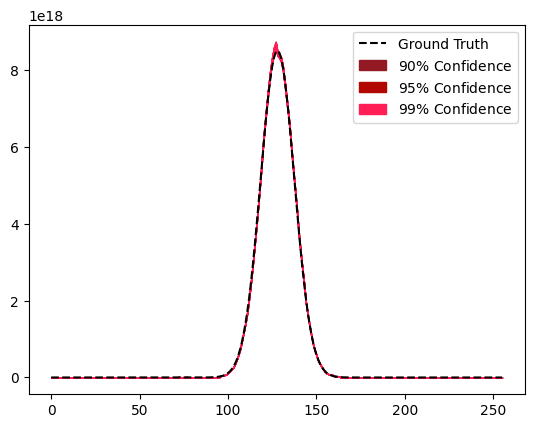

In [ ]:
plt.plot(np.arange(m_test), y_test[22][int(m_test/2)], linestyle='--', color='#000000',label='Ground Truth')
plt.fill_between(np.arange(m_test), lower_1.squeeze(), upper_1.squeeze(), color='#931A25', label='90$\%$ Confidence')
plt.fill_between(np.arange(m_test), lower_2.squeeze(), lower_1.squeeze(), color='#B20600')
plt.fill_between(np.arange(m_test), upper_2.squeeze(), upper_1.squeeze(), color='#B20600', label='95$\%$ Confidence')
plt.fill_between(np.arange(m_test), lower_3.squeeze(), lower_2.squeeze(), color='#FF1E56', label='99$\%$ Confidence')
plt.fill_between(np.arange(m_test), upper_3.squeeze(), upper_2.squeeze(), color='#FF1E56')
plt.legend()

# Dropout rate = 0.2

In [ ]:
x_test = np.load('/content/drive/MyDrive/Rings_without_Noise/xtest_16_17.npz')
x_test = x_test['arr_0']
x_test = x_test.astype('float32')

y_test = np.load('/content/drive/MyDrive/Rings_without_Noise/ytest_16_17.npz')
y_test = y_test['arr_0']
y_test = y_test.astype('float32')

In [ ]:
max_val_den = 1e19
max_val_erms = 13.32106

In [ ]:
num_img = y_test.shape[0]
m_test = y_test.shape[1]
n_test = y_test.shape[2]
num_img

109

In [ ]:
test =[]
test.append(x_test[22])
test = np.asarray(test)
test.shape

(1, 256, 256, 1)

In [ ]:
model = UNet_MCD((256,256,1),l1(1e-6),0.1)

In [ ]:
model.load_weights('/content/1e-06_MCD_P_2.h5')

In [ ]:
op = np.empty((100,256,256,1))
for i in range(100):
  op[i] = model.predict(test, verbose = 0)

In [ ]:
y_test /= 255.0
y_test *= max_val_den

In [ ]:
op /= 255.0
op *= max_val_den

In [ ]:
se = np.mean(op, axis = 0)
std = np.std(op, axis = 0)

In [ ]:
z1 = 1.645
z2 = 1.96
z3 = 2.576

In [ ]:
upper_1 = se[int(m_test/2)] + (z1 * (std[int(m_test/2)]/np.sqrt(100.0)))
lower_1 = se[int(m_test/2)] - (z1 * (std[int(m_test/2)]/np.sqrt(100.0)))

upper_2 = se[int(m_test/2)] + (z2 * (std[int(m_test/2)]/np.sqrt(100.0)))
lower_2 = se[int(m_test/2)] - (z2 * (std[int(m_test/2)]/np.sqrt(100.0)))

upper_3 = se[int(m_test/2)] + (z3 * (std[int(m_test/2)]/np.sqrt(100.0)))
lower_3 = se[int(m_test/2)] - (z3 * (std[int(m_test/2)]/np.sqrt(100.0)))

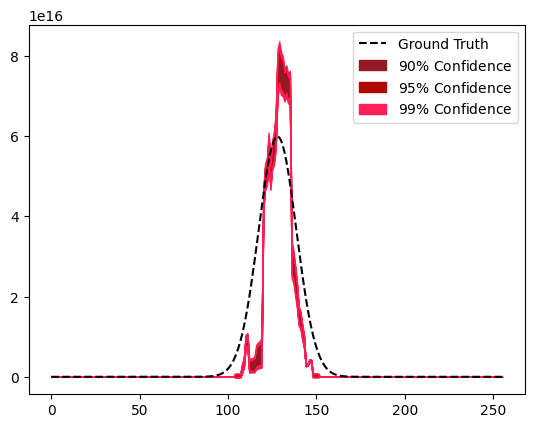

In [ ]:
plt.plot(np.arange(m_test), y_test[22][int(m_test/2)], linestyle='--', color='#000000',label='Ground Truth')
plt.fill_between(np.arange(m_test), lower_1.squeeze(), upper_1.squeeze(), color='#931A25', label='90$\%$ Confidence')
plt.fill_between(np.arange(m_test), lower_2.squeeze(), lower_1.squeeze(), color='#B20600')
plt.fill_between(np.arange(m_test), upper_2.squeeze(), upper_1.squeeze(), color='#B20600', label='95$\%$ Confidence')
plt.fill_between(np.arange(m_test), lower_3.squeeze(), lower_2.squeeze(), color='#FF1E56', label='99$\%$ Confidence')
plt.fill_between(np.arange(m_test), upper_3.squeeze(), upper_2.squeeze(), color='#FF1E56')
plt.legend()

In [ ]:
x_test = np.load('/content/drive/MyDrive/Rings_without_Noise/xtest_17_18.npz')
x_test = x_test['arr_0']
x_test = x_test.astype('float32')

y_test = np.load('/content/drive/MyDrive/Rings_without_Noise/ytest_17_18.npz')
y_test = y_test['arr_0']
y_test = y_test.astype('float32')

In [ ]:
max_val_den = 1e19
max_val_erms = 13.32106

In [ ]:
num_img = y_test.shape[0]
m_test = y_test.shape[1]
n_test = y_test.shape[2]
num_img

116

In [ ]:
test =[]
test.append(x_test[22])
test = np.asarray(test)
test.shape

(1, 256, 256, 1)

In [ ]:
model = UNet_MCD((256,256,1),l1(1e-6),0.1)

In [ ]:
model.load_weights('/content/1e-06_MCD_P_2.h5')

In [ ]:
op = np.empty((100,256,256,1))
for i in range(100):
  op[i] = model.predict(test, verbose = 0)

In [ ]:
y_test /= 255.0
y_test *= max_val_den

In [ ]:
op /= 255.0
op *= max_val_den

In [ ]:
se = np.mean(op, axis = 0)
std = np.std(op, axis = 0)

In [ ]:
z1 = 1.645
z2 = 1.96
z3 = 2.576

In [ ]:
upper_1 = se[int(m_test/2)] + (z1 * (std[int(m_test/2)]/np.sqrt(100.0)))
lower_1 = se[int(m_test/2)] - (z1 * (std[int(m_test/2)]/np.sqrt(100.0)))

upper_2 = se[int(m_test/2)] + (z2 * (std[int(m_test/2)]/np.sqrt(100.0)))
lower_2 = se[int(m_test/2)] - (z2 * (std[int(m_test/2)]/np.sqrt(100.0)))

upper_3 = se[int(m_test/2)] + (z3 * (std[int(m_test/2)]/np.sqrt(100.0)))
lower_3 = se[int(m_test/2)] - (z3 * (std[int(m_test/2)]/np.sqrt(100.0)))

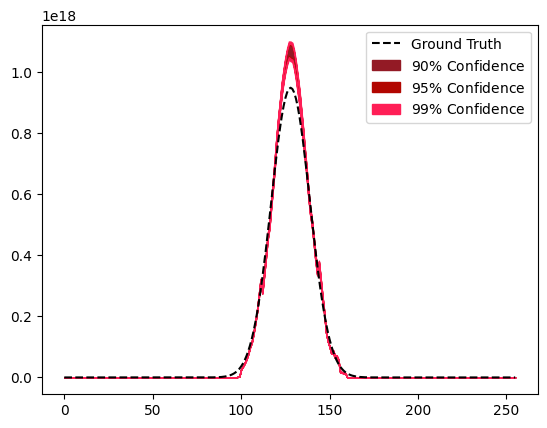

In [ ]:
plt.plot(np.arange(m_test), y_test[22][int(m_test/2)], linestyle='--', color='#000000',label='Ground Truth')
plt.fill_between(np.arange(m_test), lower_1.squeeze(), upper_1.squeeze(), color='#931A25', label='90$\%$ Confidence')
plt.fill_between(np.arange(m_test), lower_2.squeeze(), lower_1.squeeze(), color='#B20600')
plt.fill_between(np.arange(m_test), upper_2.squeeze(), upper_1.squeeze(), color='#B20600', label='95$\%$ Confidence')
plt.fill_between(np.arange(m_test), lower_3.squeeze(), lower_2.squeeze(), color='#FF1E56', label='99$\%$ Confidence')
plt.fill_between(np.arange(m_test), upper_3.squeeze(), upper_2.squeeze(), color='#FF1E56')
plt.legend()

In [ ]:
x_test = np.load('/content/drive/MyDrive/Rings_without_Noise/xtest_18_19.npz')
x_test = x_test['arr_0']
x_test = x_test.astype('float32')

y_test = np.load('/content/drive/MyDrive/Rings_without_Noise/ytest_18_19.npz')
y_test = y_test['arr_0']
y_test = y_test.astype('float32')

In [ ]:
max_val_den = 1e19
max_val_erms = 13.32106

In [ ]:
num_img = y_test.shape[0]
m_test = y_test.shape[1]
n_test = y_test.shape[2]
num_img

105

In [ ]:
test =[]
test.append(x_test[22])
test = np.asarray(test)
test.shape

(1, 256, 256, 1)

In [ ]:
model = UNet_MCD((256,256,1),l1(1e-6),0.1)

In [ ]:
model.load_weights('/content/1e-06_MCD_P_2.h5')

In [ ]:
op = np.empty((100,256,256,1))
for i in range(100):
  op[i] = model.predict(test, verbose = 0)

In [ ]:
y_test /= 255.0
y_test *= max_val_den

In [ ]:
op /= 255.0
op *= max_val_den

In [ ]:
se = np.mean(op, axis = 0)
std = np.std(op, axis = 0)

In [ ]:
z1 = 1.645
z2 = 1.96
z3 = 2.576

In [ ]:
upper_1 = se[int(m_test/2)] + (z1 * (std[int(m_test/2)]/np.sqrt(100.0)))
lower_1 = se[int(m_test/2)] - (z1 * (std[int(m_test/2)]/np.sqrt(100.0)))

upper_2 = se[int(m_test/2)] + (z2 * (std[int(m_test/2)]/np.sqrt(100.0)))
lower_2 = se[int(m_test/2)] - (z2 * (std[int(m_test/2)]/np.sqrt(100.0)))

upper_3 = se[int(m_test/2)] + (z3 * (std[int(m_test/2)]/np.sqrt(100.0)))
lower_3 = se[int(m_test/2)] - (z3 * (std[int(m_test/2)]/np.sqrt(100.0)))

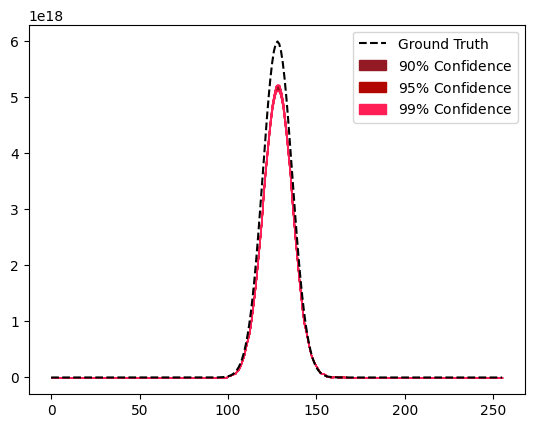

In [ ]:
plt.plot(np.arange(m_test), y_test[22][int(m_test/2)], linestyle='--', color='#000000',label='Ground Truth')
plt.fill_between(np.arange(m_test), lower_1.squeeze(), upper_1.squeeze(), color='#931A25', label='90$\%$ Confidence')
plt.fill_between(np.arange(m_test), lower_2.squeeze(), lower_1.squeeze(), color='#B20600')
plt.fill_between(np.arange(m_test), upper_2.squeeze(), upper_1.squeeze(), color='#B20600', label='95$\%$ Confidence')
plt.fill_between(np.arange(m_test), lower_3.squeeze(), lower_2.squeeze(), color='#FF1E56', label='99$\%$ Confidence')
plt.fill_between(np.arange(m_test), upper_3.squeeze(), upper_2.squeeze(), color='#FF1E56')
plt.legend()